<a href="https://colab.research.google.com/github/Scottman625/Tibame-DeepLearning/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
path = "/content/drive/MyDrive/train.zip"
f = zipfile.ZipFile(path)
f.extractall()

FileNotFoundError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


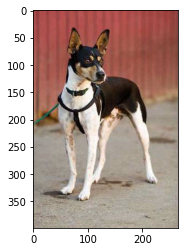

In [ ]:
import glob
import matplotlib.pyplot as plt
from PIL import Image
fs = glob.glob("train/*")
plt.imshow(Image.open(fs[10000]))

In [ ]:
import random
import pandas as pd
dogs = glob.glob("train/dog.*")
random.shuffle(dogs)
cats = glob.glob("train/cat.*")
random.shuffle(cats)
train = pd.DataFrame({
    "path":dogs[:900] + cats[:900],
    "target":[0] * 900 + [1] * 900
})
validate = pd.DataFrame({
    "path":dogs[900:950] + cats[900:950],
    "target":[0] * 50 + [1] * 50
})
test = pd.DataFrame({
    "path":dogs[950:1000] + cats[950:1000],
    "target":[0] * 50 + [1] * 50
})

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.layers import BatchNormalization
cnn = VGG16(include_top=False, input_shape=(224, 224, 3))
# compile前就設定好
for l in cnn.layers:
    l.trainable = False
clf = [
    # BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(2, activation="softmax")
]
model = Sequential(cnn.layers + clf)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [ ]:
# 一個輸出(二元分類): BinaryCrossEntropy p log 1/q + (1 - p) log 1/1-q
# 多個輸出(多元分類): CategoricalCrossEntropy pi log1/qi
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
              # "adam"也可以
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
import numpy as np
x_train = np.array(train["path"])
y_train = np.array(train["target"])
x_validate = np.array(validate["path"])
y_validate = np.array(validate["target"])
x_test = np.array(test["path"])
y_test = np.array(test["target"])

In [ ]:
from PIL import Image
from tensorflow.keras.applications.vgg16 import preprocess_input
def get_data(x, y, batch=None):
    if batch is not None:
        idx = np.random.randint(0, len(x), size=batch)
        x, y = x[idx], y[idx]
    img_pre, img_ori = [], []
    for p in x:
        img = Image.open(p).convert("RGB").resize((224, 224))
        img = np.array(img)
        img_pre.append(preprocess_input(img))
        img_ori.append(img)
    return (np.array(img_pre), np.array(img_ori), y)
x, x_ori, y = get_data(x_train, y_train, 10)
print(x.shape)
print(x_ori.shape)
print(y.shape)
# print(x)

(10, 224, 224, 3)
(10, 224, 224, 3)
(10,)


In [ ]:
xv, xv_ori, yv = get_data(x_validate, y_validate)
xt, xt_ori, yt = get_data(x_test, y_test)
print(xv.shape)
print(xt.shape)

(100, 224, 224, 3)
(100, 224, 224, 3)


In [ ]:
for i in range(50):
    x, _, y = get_data(x_train, y_train, batch=20)
    result = model.train_on_batch(x, y)
    print("train:", result)
    result = model.test_on_batch(xv, yv)
    print("validate:", result)
    print("-" * 15, i, "end", "-" * 15)

train: [4.649600028991699, 0.5]
validate: [3.6752099990844727, 0.4300000071525574]
--------------- 0 end ---------------
train: [2.0568511486053467, 0.6499999761581421]
validate: [3.3837969303131104, 0.4699999988079071]
--------------- 1 end ---------------
train: [2.47513484954834, 0.44999998807907104]
validate: [3.1375882625579834, 0.47999998927116394]
--------------- 2 end ---------------
train: [2.94061279296875, 0.5]
validate: [2.9377455711364746, 0.5400000214576721]
--------------- 3 end ---------------
train: [3.6575000286102295, 0.6499999761581421]
validate: [2.6818432807922363, 0.5600000023841858]
--------------- 4 end ---------------
train: [0.9735905528068542, 0.75]
validate: [2.4614017009735107, 0.6200000047683716]
--------------- 5 end ---------------
train: [2.573225975036621, 0.550000011920929]
validate: [2.242218017578125, 0.6700000166893005]
--------------- 6 end ---------------
train: [2.160179853439331, 0.6000000238418579]
validate: [2.0556702613830566, 0.70999997854

In [ ]:
pre = model.predict(xt).argmax(axis=1)
model.evaluate(xt, yt)

4/4 [==============================] - 1s 202ms/step - loss: 0.2226 - accuracy: 0.9400


[0.222595676779747, 0.9399999976158142]

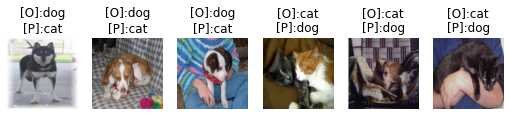

In [ ]:
import numpy as np
# 找出True(預測錯誤)的位置
idx = np.nonzero(pre != yt)[0]
idx = idx[:200]
pre_false_label = yt[idx]
pre_false_pre = pre[idx]
pre_false_img = xt_ori[idx]
# !
trans = ["dog", "cat"]
plt.figure(figsize=(15, 5))
width = 10
height = len(idx) // width + 1
for i in range(len(idx)):
    plt.subplot(height, width, i+1)
    t = "[O]:{}\n[P]:{}".format(trans[pre_false_label[i]], trans[pre_false_pre[i]])
    plt.title(t)
    plt.axis("off")
    plt.imshow(pre_false_img[i])

url:https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQost9E0eEgKclw9NdiMa_4chBS9YvuKI6ZlL0SZpnsjZyoilH0uUJ8u6lZwBk2UoJiPQ0&usqp=CAU
dog 的機率: 0.867
cat 的機率: 0.133


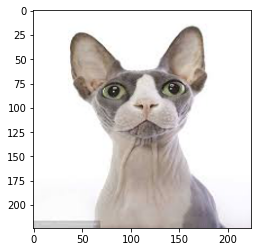

In [ ]:
import requests
# pillow
from PIL import Image
url = input("url:")
response = requests.get(url, stream=True)
img = Image.open(response.raw).convert("RGB").resize((224, 224))
img_np = np.array(img).reshape(1, 224, 224, 3)
# (32, 32, 3) -> (1, 32, 32, 3)
img_np_pre = preprocess_input(img_np)
proba = model.predict(img_np_pre)[0]
for p, n in zip(proba, trans):
    print(n, "的機率:", round(p, 3))
plt.imshow(img)